# Tutorial 1: Entanglement Forged VQE for the $TS$ molecule

In this tutorial, we apply Entanglement Forged VQE to compute the energy of a $TS$ molecule. We will use a separate list of bitstrings for subsystems U and V.

### Importing the relevant modules

In [1]:
from matplotlib import pyplot as plt
import numpy as np

from qiskit import Aer
from qiskit.circuit import QuantumCircuit, Parameter
from qiskit_nature.drivers import Molecule
from qiskit_nature.drivers.second_quantization import PySCFDriver
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem
from qiskit_nature.mappers.second_quantization import JordanWignerMapper
from qiskit_nature.algorithms.ground_state_solvers import GroundStateEigensolver, NumPyMinimumEigensolverFactory
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.properties.second_quantization.electronic.bases import ElectronicBasis
from qiskit_nature.transformers.second_quantization.electronic.active_space_transformer import ActiveSpaceTransformer

from entanglement_forging import EntanglementForgedConfig, EntanglementForgedDriver, EntanglementForgedGroundStateSolver

## Setting up the problem (the chemistry)

We start by setting up the chemical problem. 

In [2]:
molecule = Molecule(geometry = [['C',[-1.662349902448, -0.695322331415, -0.307726967072]],
                                ['C',[0.477506399751, -1.159887599109, 0.386176362728]],
                                ['C',[0.465033028474, 1.178065976344, 0.346006737462]],
                                ['C',[-1.669162693941, 0.665549642529, -0.333932016197]],
                                ['C',[0.353240259603, 0.025254735280, 1.345385392500]],
                                ['H',[1.236672966467, 0.041367363616, 2.008294800099]],
                                ['H',[-0.545529019687, 0.031307436573, 1.971273375160]],
                                ['H',[0.387169841664, -2.199386408363, 0.712397189321]],
                                ['H',[0.365402809281, 2.227055868201, 0.637306711025]],
                                ['H',[-1.573663113993, -1.275918322039, -1.226211748221]],
                                ['H',[-1.583878458115, 1.210474104515, -1.274313037410]],
                                ['H',[-2.033162089723, -1.244377161302, 0.558595832016]],
                                ['H',[-2.046566709656, 1.244731052782, 0.509648077185]],
                                ['C',[1.139953226957, -0.725010259076, -0.736843572958]],
                                ['C',[1.131273764619, 0.711596029626, -0.762213847697]],
                                ['H',[1.502490625700, -1.357451877629, -1.549059430283]],
                                ['H',[1.487075446023, 1.319266551725, -1.596040408218]]],                                   
                    charge       = 0,
                    multiplicity = 1)

driver    = PySCFDriver.from_molecule(molecule=molecule,basis='sto-3g')
converter = QubitConverter(JordanWignerMapper())

### Classical Result
For comparison, we also compute the classical result. 

In [3]:
#Molecular problem was transformed as the Hamiltonian in the 4 orbital active space. 

transformer= ActiveSpaceTransformer(num_electrons=4, num_molecular_orbitals=4)
problem_reduced = ElectronicStructureProblem(driver, [transformer])
solver = GroundStateEigensolver(converter, NumPyMinimumEigensolverFactory(use_default_filter_criterion=False))
result = solver.solve(problem_reduced)
print('Classical energy = ', result.total_energies[0])

Classical energy =  (-267.524787205886+0j)


# Calculate integrals and energy shift needed for operator decomposition

In [4]:
H_fermionic = problem_reduced.second_q_ops()[0]
electronic_energy_object = problem_reduced.grouped_property_transformed.get_property('ElectronicEnergy')
energy_shift = electronic_energy_object._shift['ActiveSpaceTransformer']+electronic_energy_object._nuclear_repulsion_energy

#These are the integrals in the molecular orbital basis retrieved from the 4 orbital active space. 

one_body_integrals_alpha = electronic_energy_object.get_electronic_integral(ElectronicBasis.MO, 1)._matrices[0]
one_body_integrals_beta = electronic_energy_object.get_electronic_integral(ElectronicBasis.MO, 1)._matrices[1]

two_body_integrals_alpha_alpha = electronic_energy_object.get_electronic_integral(ElectronicBasis.MO, 2)._matrices[0]
two_body_integrals_beta_alpha = electronic_energy_object.get_electronic_integral(ElectronicBasis.MO, 2)._matrices[1]
two_body_integrals_beta_beta = electronic_energy_object.get_electronic_integral(ElectronicBasis.MO, 2)._matrices[2]
two_body_integrals_alpha_beta = electronic_energy_object.get_electronic_integral(ElectronicBasis.MO, 2)._matrices[3]

## Create an ElectronicStructureProblem from our EF Driver and perform second quantization

In [5]:
#Setting up the entanglement forging problem in the 4 orbital active space:
driver = EntanglementForgedDriver(hcore=one_body_integrals_alpha,
                                  mo_coeff=np.eye(4,4),
                                  eri=two_body_integrals_alpha_alpha,
                                  num_alpha=2,
                                  num_beta=2,
                                  nuclear_repulsion_energy=energy_shift)
problem = ElectronicStructureProblem(driver)
problem.second_q_ops()

converter = QubitConverter(JordanWignerMapper())

## Specify different Schmidt coefficients for each subsystem, U and V, by creating two separate lists of bitstrings.

In [6]:
bitstrings_u = [[1, 1, 0, 0], [1, 0, 1, 0], [0, 1, 0, 1], [0, 1, 1, 0]]
bitstrings_v = [[1, 1, 0, 0], [1, 0, 1, 0], [0, 1, 0, 1], [1, 0, 0, 1]]

brickwall =[(2,3),(1,2),(0,1),(2,3),(1,2),(2,3)]

n_theta    = len(brickwall)
nqubit = len(bitstrings_u[0])
theta    = Parameter('θ')
hop_gate = QuantumCircuit(2, name="Hop gate")
hop_gate.h(0)
hop_gate.cx(1, 0)
hop_gate.cx(0, 1)
hop_gate.ry(-theta, 0)
hop_gate.ry(-theta, 1)
hop_gate.cx(0, 1)
hop_gate.h(0)

theta_vec = [Parameter('θ%d'%i) for i in range(n_theta)]

## Create the ansatz circuit. Note that we will use the same circuit for both subsystems, U and V.

In [7]:
ansatz = QuantumCircuit(nqubit)
for m,(i,j) in enumerate(brickwall):
    ansatz.append(hop_gate.to_gate({theta:theta_vec[m]}),[i,j])

ansatz.draw('text', justify='right', fold=-1)

┌───────────────┐                                  
q_0: ──────────────────────────────────┤0              ├──────────────────────────────────
                      ┌───────────────┐│  Hop gate(θ2) │┌───────────────┐                 
q_1: ─────────────────┤0              ├┤1              ├┤0              ├─────────────────
     ┌───────────────┐│  Hop gate(θ1) │├───────────────┤│  Hop gate(θ4) │┌───────────────┐
q_2: ┤0              ├┤1              ├┤0              ├┤1              ├┤0              ├
     │  Hop gate(θ0) │└───────────────┘│  Hop gate(θ3) │└───────────────┘│  Hop gate(θ5) │
q_3: ┤1              ├─────────────────┤1              ├─────────────────┤1              ├
     └───────────────┘                 └───────────────┘                 └───────────────┘

## Configure the EF algorithm

In [8]:
backend = Aer.get_backend('statevector_simulator')
config = EntanglementForgedConfig(backend = backend, maxiter = 30, initial_params=[0.1]*n_theta,optimizer_name='L_BFGS_B')

## Run the EF algorithm and print the results

In [9]:
calc = EntanglementForgedGroundStateSolver(qubit_converter=converter, ansatz=ansatz, bitstrings_u=bitstrings_u, bitstrings_v=bitstrings_v, config=config)
res = calc.solve(problem)

res

Ground state energy (Hartree): (-267.51266554757825+0j)
Schmidt values: [-0.96640826  0.17797529  0.156334    0.09969728]
Optimizer parameters: [-0.24814692  1.03693875  0.01154805  0.00851938  1.03519701  0.24844022]

## We see the ground state energy converged toward the target value and that one of our Schmidt coefficients dominates the others.

Estimated ground state energy vs Optimizer Iterations


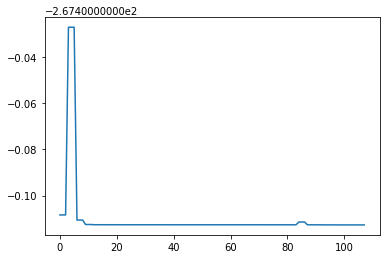

Estimated Schmidt coefficients vs Optimizer Iterations


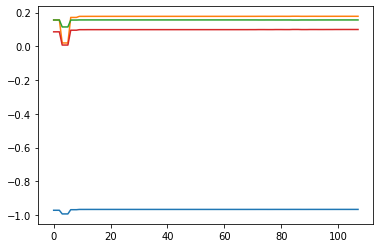

In [12]:
print('Estimated ground state energy vs Optimizer Iterations')
plt.plot([e[0] for e in res.get_energies_history()])
plt.show()
print('Estimated Schmidt coefficients vs Optimizer Iterations')
plt.plot([s[0] for s in res.get_schmidts_history()])
plt.show()

In [11]:
import qiskit.tools.jupyter

%qiskit_version_table
%qiskit_copyright